# used import

In [162]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


lightgbm을 사용하기 위하여 모듈을 설치

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler  #scaling
import numpy as np 
import matplotlib.pylab as plt
import time
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier 
import catboost

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.utils import np_utils

In [39]:
import xgboost as xgb
from xgboost import plot_importance

In [43]:
from sklearn.metrics import classification_report

# data load

In [13]:
data=pd.read_csv('C:/Users/CPB06GameN/train.csv',parse_dates=['Dates'])
data['Year']=data['Dates'].dt.year
data['Month']=data['Dates'].dt.month
data['Hour']=data['Dates'].dt.hour
data['Minute']=data['Dates'].dt.minute

Dates에서 Year, Month, Hour, Minute를 뽑아서 변수로 추가 생성

In [14]:
#basic information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Dates       878049 non-null  datetime64[ns]
 1   Category    878049 non-null  object        
 2   Descript    878049 non-null  object        
 3   DayOfWeek   878049 non-null  object        
 4   PdDistrict  878049 non-null  object        
 5   Resolution  878049 non-null  object        
 6   Address     878049 non-null  object        
 7   X           878049 non-null  float64       
 8   Y           878049 non-null  float64       
 9   Year        878049 non-null  int64         
 10  Month       878049 non-null  int64         
 11  Hour        878049 non-null  int64         
 12  Minute      878049 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(6)
memory usage: 87.1+ MB


- datetime : 1
- Category : 6
- float : 2
- int : 4

In [15]:
#data shape
print('The shape of data is:',data.shape)

The shape of data is: (878049, 13)


878049개의 행과 13개의 변수를 가지고 있다.

In [16]:
data.columns[data.isnull().any()]

Index([], dtype='object')

- null값이 있는 열을 추출
- null값이 존재하지 않았음

# outlier check

{'whiskers': [<matplotlib.lines.Line2D at 0x21ec0250588>,
 'caps': [<matplotlib.lines.Line2D at 0x21ebfbc6a48>,
 'boxes': [<matplotlib.lines.Line2D at 0x21ebff000c8>],
 'medians': [<matplotlib.lines.Line2D at 0x21ebbc90888>],
 'fliers': [<matplotlib.lines.Line2D at 0x21eba728cc8>],
 'means': []}

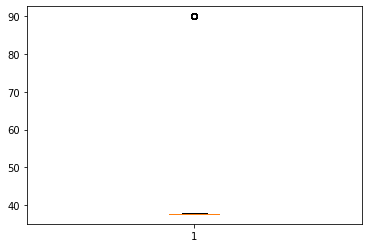

In [17]:
#outlier
plt.boxplot(data['Y'])

- 샌프란시스코의 평균 위도 : 37도
- 위도가 90도로 찍힌 이상치 발견
- 테스트 데이터를 확인한 결과 이상치는 존재하지 않았음

In [18]:
data[data['Y'] > 50 ].count()

Dates         67
Category      67
Descript      67
DayOfWeek     67
PdDistrict    67
Resolution    67
Address       67
X             67
Y             67
Year          67
Month         67
Hour          67
Minute        67
dtype: int64

총 67개의 이상치가 확인됨

In [19]:
data = data[data['Y'] < 50]
data.shape

(877982, 13)

67개의 이상치를 제거

{'whiskers': [<matplotlib.lines.Line2D at 0x21ebfbe3e08>,
 'caps': [<matplotlib.lines.Line2D at 0x21eba723c08>,
 'boxes': [<matplotlib.lines.Line2D at 0x21ebb8d1488>],
 'medians': [<matplotlib.lines.Line2D at 0x21eba71fb88>],
 'fliers': [<matplotlib.lines.Line2D at 0x21eba71fc88>],
 'means': []}

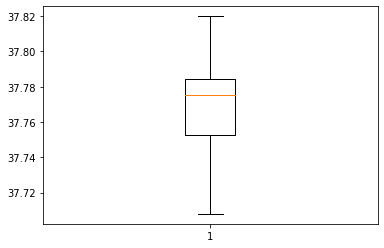

In [20]:
plt.boxplot(data["Y"])

이상치가 제거된 위도에 대한 boxplot

## feature engine

In [21]:
data['Address'].value_counts()

800 Block of BRYANT ST         26533
800 Block of MARKET ST          6581
2000 Block of MISSION ST        5097
1000 Block of POTRERO AV        4063
900 Block of MARKET ST          3251
                               ...  
1200 Block of TWIN PEAKS BL        1
VICENTE ST / FORESTSIDE AV         1
1000 Block of STEVENSON ST         1
WALLER ST / POTOMAC ST             1
GOLETA AV / SLOAT BL               1
Name: Address, Length: 23191, dtype: int64

 - Address를 보면 총 23000여개의 거리가 있음
 - Address변수를 get_dummies를 하면 변수가 너무 많아짐
 - 범죄를 예측하는 것이기 때문에 Address가 중요한 변수라고 생각함

In [22]:
data['Block'] = data['Address'].str.contains('block', case=False)
data['Block'] = data['Block'].map(lambda x: 1 if  x == True else 0)

Address를 보면 'Block'이라는 단어를 찾을 수 있는데

따라서, Block이 있으면 1, 없으면 0으로 변경

In [23]:
data['Resolution'].value_counts()

NONE                                      526757
ARREST, BOOKED                            206384
ARREST, CITED                              76994
LOCATED                                    17101
PSYCHOPATHIC CASE                          14533
UNFOUNDED                                   9584
JUVENILE BOOKED                             5563
COMPLAINANT REFUSES TO PROSECUTE            3974
DISTRICT ATTORNEY REFUSES TO PROSECUTE      3934
NOT PROSECUTED                              3714
JUVENILE CITED                              3332
PROSECUTED BY OUTSIDE AGENCY                2504
EXCEPTIONAL CLEARANCE                       1530
JUVENILE ADMONISHED                         1455
JUVENILE DIVERTED                            355
CLEARED-CONTACT JUVENILE FOR MORE INFO       217
PROSECUTED FOR LESSER OFFENSE                 51
Name: Resolution, dtype: int64

총 17개의 범죄 해결 유무를 가지고 있음

In [24]:
data['Solution'] = data['Resolution'].str.contains('NONE', case= False)
data['Solution'] = data['Solution'].map(lambda x: 0 if  x == True else 1)

같은 방법으로 Resolution의 데이터도 

범죄가 해결되었다면 범죄가 어떤 방법으로 해결되어 있는지 나와있으며, 해결되지 않았다면 None으로 입력되어있다.

따라서 범죄가 해결되었다면 1, 범죄가 해결되지 않았다면 0으로 변경

In [25]:
data= data.drop(["Descript", "Resolution",'Dates','Address'], axis = 1)

필요없는 변수를 제거

In [26]:
X = data[['DayOfWeek','PdDistrict','X','Y','Year','Month','Hour','Minute','Block','Solution']]
y = data[['Category']]

X, y 설정
 - X : DayOfWeek(요일), PdDistrict(경찰서구역), X(경도), Y(위도), Month(열), Hour(시간), Minute(분), Block, Solution
          
 - y : 범죄종류(예측할 변수)

In [27]:
X_dummies = pd.get_dummies(X,columns=['DayOfWeek', 'PdDistrict'])

명목형 변수인 DayOfWeek(요일), PdDistrict(경찰서구역)을 get_dummies를 사용하여 각각의 변수를 0,1로 변경

In [28]:
X_dummies

,X,Y,Year,Month,Hour,Minute,Block,Solution,DayOfWeek_Friday,DayOfWeek_Monday,...,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_RICHMOND,PdDistrict_SOUTHERN,PdDistrict_TARAVAL,PdDistrict_TENDERLOIN
0,-122.425892,37.774599,2015,5,23,53,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,-122.425892,37.774599,2015,5,23,53,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
2,-122.424363,37.800414,2015,5,23,33,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,-122.426995,37.800873,2015,5,23,30,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,-122.438738,37.771541,2015,5,23,30,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878044,-122.459033,37.714056,2003,1,0,15,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
878045,-122.447364,37.731948,2003,1,0,1,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0
878046,-122.403390,37.780266,2003,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
878047,-122.390531,37.780607,2003,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


## Train , Test

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y,random_state=0)

traindata와 testdata로 분리

## 스케일링

In [30]:
scaler = MinMaxScaler()

 - MinMaxScaler는 이상치에 민감함
 - 그러나, 앞에서 이상치를 제거했기 때문에 MinMaxScaler로 진행

In [31]:
#데이터변환
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [32]:
X_train_scaled

array([[0.74693575, 0.76724447, 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.55283925, 0.28226468, 0.75      , ..., 0.        , 0.        ,
        0.        ],
       [0.73486576, 0.50078256, 0.25      , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.68625308, 0.67061816, 0.83333333, ..., 0.        , 0.        ,
        1.        ],
       [0.71549904, 0.70194662, 0.5       , ..., 0.        , 0.        ,
        1.        ],
       [0.85541684, 0.10084549, 0.66666667, ..., 0.        , 0.        ,
        0.        ]])

In [33]:
X_test_scaled

array([[0.43622652, 0.4935735 , 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       [0.39579723, 0.62281886, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.82122003, 0.2187525 , 0.83333333, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.40814523, 0.52165352, 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.83984653, 0.29285566, 0.83333333, ..., 0.        , 0.        ,
        0.        ],
       [0.60298016, 0.73393049, 0.25      , ..., 0.        , 0.        ,
        0.        ]])

In [34]:
train_features = X_train_scaled[:data.shape[0]]
train_features

array([[0.74693575, 0.76724447, 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.55283925, 0.28226468, 0.75      , ..., 0.        , 0.        ,
        0.        ],
       [0.73486576, 0.50078256, 0.25      , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.68625308, 0.67061816, 0.83333333, ..., 0.        , 0.        ,
        1.        ],
       [0.71549904, 0.70194662, 0.5       , ..., 0.        , 0.        ,
        1.        ],
       [0.85541684, 0.10084549, 0.66666667, ..., 0.        , 0.        ,
        0.        ]])

In [35]:
test_features = X_test_scaled[:data.shape[0]]
test_features

array([[0.43622652, 0.4935735 , 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       [0.39579723, 0.62281886, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.82122003, 0.2187525 , 0.83333333, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.40814523, 0.52165352, 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.83984653, 0.29285566, 0.83333333, ..., 0.        , 0.        ,
        0.        ],
       [0.60298016, 0.73393049, 0.25      , ..., 0.        , 0.        ,
        0.        ]])

사용하기 편하게 train_features와 test_features로 이름 변경

In [36]:
y_train

,Category
410027,BURGLARY
179645,LARCENY/THEFT
599493,RECOVERED VEHICLE
815150,NON-CRIMINAL
95800,KIDNAPPING
...,...
359783,SUSPICIOUS OCC
152315,NON-CRIMINAL
117952,LARCENY/THEFT
435829,DRUG/NARCOTIC


In [37]:
train_labels = pd.get_dummies(y_train['Category']).values
train_labels = np.argmax(train_labels, axis=1)

In [38]:
test_labels = pd.get_dummies(y_test['Category']).values
test_labels = np.argmax(test_labels, axis=1)

동일하게 train_labels와 test_labels로 이름 변경

## LightGBM

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

https://nurilee.com/lightgbm-definition-parameter-tuning/

GBM(Gradient Boost Machine) 기반
- 리프 중심 트리분할(Leaf Wise) 방식 : 최대 손실 값을 가지는 리프 노드를 지속적으로 분할하면서 트리   가 깊어지고 비대칭적으로 생성 (예측 오류 손실 최소화)

장점
- XGBoost 대비 더 빠른 학습과 예측 수행 시간
- 더 작은 메모리 사용량

단점
- 적은 데이터 세트에 적용할 경우 과적합 발생


In [16]:
import lightgbm as lgb

### GridSearch - min_child_weight

In [30]:
start = time.time()
param_test11 = {
 'min_child_weight':[0.001,0.01,0.1,1,10]
}
gsearch11 = GridSearchCV(estimator = LGBMClassifier(learning_rate =0.1,
                                                    n_estimators=500, 
                                                   max_depth=-1,num_leaves =31,
                                                   objective="multiclass",
                                                   min_child_weight=1, 
                                                   gamma=0.08, 
                                                   subsample=0.7,
                                                   colsample_bytree=0.6, n_jobs = -1), 
param_grid = param_test11,iid=False, cv=5)
gsearch11.fit(train_features,train_labels)
print(time.time() - start)
gsearch11.cv_results_, gsearch11.best_params_, gsearch11.best_score_

C:\Users\CPB06GameN\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\CPB06GameN\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


14393.954134702682


({'mean_fit_time': array([389.62030115, 409.37169633, 473.08637786, 800.06717739,
         412.44597178]),
  'std_fit_time': array([ 35.1336823 ,   2.84111844, 108.22625099, 365.51372159,
          24.89072727]),
  'mean_score_time': array([43.53756833, 47.34809842, 70.91166549, 90.41949916, 43.78423409]),
  'std_score_time': array([11.73811864,  2.34812704, 39.47763607, 54.18686467,  6.28879267]),
  'param_min_child_weight': masked_array(data=[0.001, 0.01, 0.1, 1, 10],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_child_weight': 0.001},
   {'min_child_weight': 0.01},
   {'min_child_weight': 0.1},
   {'min_child_weight': 1},
   {'min_child_weight': 10}],
  'split0_test_score': array([0.16618324, 0.35096964, 0.3516834 , 0.3525642 , 0.35273884]),
  'split1_test_score': array([0.18254022, 0.35207332, 0.35284782, 0.35325786, 0.35393365]),
  'split2_test_score': array([0.17883475, 0.3505319 , 0.35095712, 0.3

- learning_rate : 학습속도 향상, 훈련시 학습 속도를 축소하기 위하여 사용
- n_estimators : 트리의 수
- max_depth : 최대 트리 깊이
- num_leaves : 최대 나뭇잎
- objective : 학습 목표 지정(회귀 / 분류)
- min_child_weight : 가중치의 최소합계 (과적합을 막을 때 씀)
- subsample : 훈련 인스턴스의 서브 샘플링 비율
- colsample_bytree : 각 트리를 구성 할 떄의 열의 하위 샘플 비율
- n_jobs :병렬 스레드 수


데이터의 수가 많다보니 GridSearch의 param을 min_child_weight만 주고 실행을 함
- 'min_child_weight':[0.001,0.01,0.1,1,10]으로 진행을 하였고 최적의 min_child_weight는 10이 출력됨

In [32]:
gsearch11.best_score_

0.3534957474523461

GridSearch를 했을 때 best_score는 0.3534,

In [202]:
lgb_clf = LGBMClassifier(learning_rate =0.1,n_estimators=500, 
               max_depth=-1,num_leaves =31,
               objective="multiclass", min_child_weight=10, 
               gamma=0.08, subsample=0.7, colsample_bytree=0.6, n_jobs = -1)

In [203]:
lgb_clf.fit(train_features, train_labels)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
               gamma=0.08, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=10,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
               objective='multiclass', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=0.7,
               subsample_for_bin=200000, subsample_freq=0)

GridSearch를 한 결과를 가지고 train데이터에 학습

In [204]:
print ("Train Accuracy : {:.3f}".format(lgb_clf.score(train_features, train_labels)))
print ("Test Accuracy : {:.3f}".format(lgb_clf.score(test_features, test_labels)))

Train Accuracy : 0.377
Test Accuracy : 0.355


In [205]:
pred_lgb = lgb_clf.predict(test_features)
print(classification_report(test_labels,pred_lgb))

C:\Users\CPB06GameN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.10      0.01      0.02       380
           1       0.22      0.20      0.21     19183
           2       0.00      0.00      0.00       100
           3       0.00      0.00      0.00        63
           4       0.27      0.08      0.12      9109
           5       0.16      0.04      0.07      1038
           6       0.06      0.00      0.01       593
           7       0.39      0.47      0.43     13506
           8       0.14      0.01      0.02      1105
           9       0.12      0.01      0.02       295
          10       0.00      0.00      0.00        55
          11       0.24      0.07      0.11       115
          12       0.23      0.09      0.13      2648
          13       0.26      0.02      0.04      4082
          14       0.00      0.00      0.00        41
          15       0.00      0.00      0.00       616
          16       0.38      0.82      0.52     43509
          17       0.38    

그 결과 모델이 예측한 값과 실제값을 비교한 결과 
 - accuracy : 0.35

### Lightgbm_ feature importance

In [113]:
len(X_dummies.columns)

25

In [114]:
len(lgb_clf.feature_importances_)

25

In [117]:
np.argsort(lgb_clf.feature_importances_)[::-1]

array([ 0,  1,  5,  4,  2,  3,  7,  6, 10, 11,  8, 13, 12, 14,  9, 22, 18,
       19, 24, 17, 15, 16, 20, 23, 21], dtype=int64)

In [120]:
X_dummies.columns[np.argsort(lgb_clf.feature_importances_)[::-1]][:10]

Index(['X', 'Y', 'Minute', 'Hour', 'Year', 'Month', 'Solution', 'Block',
       'DayOfWeek_Saturday', 'DayOfWeek_Sunday'],
      dtype='object')

Plot feature importances...


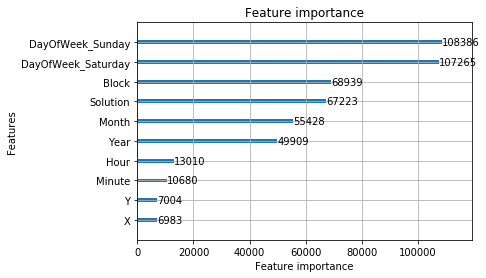

In [129]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
from lightgbm import plot_importance
print('Plot feature importances...')
plot_importance(lgb_clf, max_num_features=10, ax=ax)
ax.set_yticklabels(X_dummies.columns[np.argsort(lgb_clf.feature_importances_)[::-1]][:10])
plt.show()

lightgbm모델의 feature importances 결과
 - DayOfWeek_Sunday와 DayOfWeek_Saturday가 중요한 특성으로 나타났으며
 - 새로 추가한 변수인 Block과 Solution 또한 중요한 특성으로 나타남

## CatBoostClassifier

GBM(Gradient Boost Machine) 기반
- 균형트리분할(Level Wise) 방식
- Orderd Boosting 방식

장점
- GPU속도가 가장 빠름
- 예측시간 감소
- 파라미터에 영향을 크게 받지 않음

단점
- Sparse 한 Matrix 는 처리하지 못함
- 데이터 대부분이 수치형 변수인 경우 Lightgbm보다 학습 속도가 느림


In [162]:
cbc_clf = catboost.CatBoostClassifier(
    random_seed=0,
    iterations=1000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton',
    task_type="GPU",
    verbose=50
)

In [163]:
cbc_clf.fit(train_features, train_labels, eval_set= (test_features,test_labels))

0:	learn: 3.5085754	test: 3.5087556	best: 3.5087556 (0)	total: 196ms	remaining: 3m 15s
50:	learn: 2.3801803	test: 2.3829687	best: 2.3829687 (50)	total: 9.22s	remaining: 2m 51s
100:	learn: 2.2617313	test: 2.2664626	best: 2.2664626 (100)	total: 18.1s	remaining: 2m 40s
150:	learn: 2.2268368	test: 2.2331475	best: 2.2331475 (150)	total: 26.9s	remaining: 2m 30s
200:	learn: 2.2080935	test: 2.2158784	best: 2.2158784 (200)	total: 35.7s	remaining: 2m 21s
250:	learn: 2.1941082	test: 2.2033287	best: 2.2033287 (250)	total: 44.6s	remaining: 2m 12s
300:	learn: 2.1833799	test: 2.1940860	best: 2.1940860 (300)	total: 53.7s	remaining: 2m 4s
350:	learn: 2.1745185	test: 2.1867010	best: 2.1867010 (350)	total: 1m 2s	remaining: 1m 55s
400:	learn: 2.1671879	test: 2.1808850	best: 2.1808850 (400)	total: 1m 11s	remaining: 1m 46s
450:	learn: 2.1608481	test: 2.1758335	best: 2.1758335 (450)	total: 1m 20s	remaining: 1m 37s
500:	learn: 2.1548026	test: 2.1710847	best: 2.1710847 (500)	total: 1m 28s	remaining: 1m 28s
550

In [164]:
print ("Train Accuracy : {:.3f}".format(cbc_clf.score(train_features, train_labels)))
print ("Test Accuracy : {:.3f}".format(cbc_clf.score(test_features, test_labels)))

Train Accuracy : 0.343
Test Accuracy : 0.338


In [165]:
pred_cbc = cbc_clf.predict(test_features)
print(classification_report(test_labels,pred_cbc))

C:\Users\CPB06GameN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       380
           1       0.21      0.18      0.19     19183
           2       0.00      0.00      0.00       100
           3       0.00      0.00      0.00        63
           4       0.23      0.04      0.07      9109
           5       0.25      0.04      0.07      1038
           6       0.00      0.00      0.00       593
           7       0.37      0.43      0.40     13506
           8       0.00      0.00      0.00      1105
           9       0.00      0.00      0.00       295
          10       0.00      0.00      0.00        55
          11       0.00      0.00      0.00       115
          12       0.22      0.04      0.07      2648
          13       0.24      0.01      0.01      4082
          14       0.00      0.00      0.00        41
          15       0.00      0.00      0.00       616
          16       0.36      0.83      0.50     43509
          17       1.00    

그 결과 모델이 예측한 값과 실제값을 비교한 결과 
 - accuracy : 0.34

### catboost_  feature importances

In [166]:
cbc_clf.feature_importances_

array([12.9215335 , 15.32752003,  8.19036702,  1.26736152,  9.58687124,
       12.2724902 ,  8.28133882, 22.62412781,  0.29611283,  0.09592275,
        0.70698197,  0.8254893 ,  0.1058405 ,  0.08313576,  0.33849455,
        0.20996979,  0.39691711,  0.2325933 ,  1.74738859,  0.8732543 ,
        0.70378737,  0.10182338,  1.1762929 ,  0.20636095,  1.42802451])

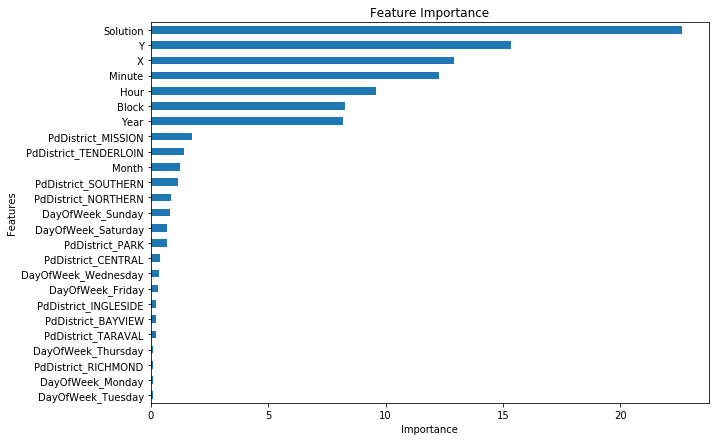

In [167]:
fea_imp = pd.DataFrame({'imp': cbc_clf.feature_importances_, 'col': X_dummies.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

- Catboost에서는 lightgbm과 다르게 Solution이 제일 중요한 변수로 작용을 하였고 
- 그 다음으로 Y(위도), X(경도), Minute(분)이 중요한 변수로 작용을 하였음

## Deep Learning

In [169]:
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoder.fit(y_test)
encoded_y_test = encoder.transform(y_test)

C:\Users\CPB06GameN\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CPB06GameN\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [170]:
one_hot_y_train  = np_utils.to_categorical(encoded_y_train)
one_hot_y_test = np_utils.to_categorical(encoded_y_test)

In [171]:
one_hot_y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Deep Learning을 진행하기 위해서 y값을 one-hot-encoding을 사용하였음

 최적의 model, parameter, validation score, step을 구할 수 있는 GridSearch를 사용

In [174]:
def tuning_model(layers=(64,), dropRate=.5, lr=.001, alpha=.01, 
                 input_shape=(25,)):
    # default lr=.001, L2alpha=.01
    import keras
    from keras.models import Sequential
    from keras.layers import Dense, Dropout
    from keras.regularizers import l2
    from keras.optimizers import rmsprop
    m = Sequential()
    for i in range(len(layers)):
        if i == 0:
            m.add(Dense(layers[i], activation='relu',
                               kernel_regularizer = l2(alpha), 
                               input_shape=input_shape))
        else:
            m.add(Dense(layers[i], activation='relu', 
                               kernel_regularizer = l2(alpha)))
        if dropRate: m.add(Dropout(dropRate))
    m.add(Dense(39, activation='softmax'))
    m.compile(optimizer=rmsprop(lr=lr),loss='categorical_crossentropy',
              metrics=['acc'])
    return m

In [185]:
import numpy as np
best_m, best_params, best_val_score, best_step = None, {}, 0, 0
for lr in [0.01, 0.005, 0.001, 0.0005]:
    for a in [0.01, 0.005, 0.001, 0.0005]:
        m = tuning_model(lr=lr, alpha=a)
        h = m.fit(X_train_scaled, one_hot_y_train, epochs=20, verbose=0,
                  batch_size=512, validation_split=.2)
        maxidx = np.array(h.history['val_acc']).argmax()
        prtstr = "lr = %.4f, alpha = %.4f : best val score = %.5f, best step = %d"
        print(prtstr %(lr, a, h.history['val_acc'][maxidx], maxidx))
        if h.history['val_acc'][maxidx] > best_val_score:
            best_m, best_step = m, maxidx
            best_params['lr'], best_params['alpha'] = lr, a
            best_val_score = h.history['val_acc'][maxidx]

lr = 0.0100, alpha = 0.0100 : best val score = 0.29108, best step = 11
lr = 0.0100, alpha = 0.0050 : best val score = 0.29099, best step = 7
lr = 0.0100, alpha = 0.0010 : best val score = 0.29314, best step = 8
lr = 0.0100, alpha = 0.0005 : best val score = 0.29334, best step = 3
lr = 0.0050, alpha = 0.0100 : best val score = 0.29194, best step = 10
lr = 0.0050, alpha = 0.0050 : best val score = 0.29369, best step = 13
lr = 0.0050, alpha = 0.0010 : best val score = 0.29421, best step = 9
lr = 0.0050, alpha = 0.0005 : best val score = 0.29560, best step = 4
lr = 0.0010, alpha = 0.0100 : best val score = 0.29313, best step = 17
lr = 0.0010, alpha = 0.0050 : best val score = 0.29421, best step = 18
lr = 0.0010, alpha = 0.0010 : best val score = 0.29631, best step = 18
lr = 0.0010, alpha = 0.0005 : best val score = 0.29645, best step = 19
lr = 0.0005, alpha = 0.0100 : best val score = 0.29199, best step = 18
lr = 0.0005, alpha = 0.0050 : best val score = 0.29207, best step = 17
lr = 0.0005

In [188]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_93 (Dense)             (None, 64)                1664      
_________________________________________________________________
dropout_35 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_94 (Dense)             (None, 39)                2535      
Total params: 4,199
Trainable params: 4,199
Non-trainable params: 0
_________________________________________________________________


In [189]:
print(best_params)
print('best val accuracy= %.5f, best step= %d' %(best_val_score, best_step))

{'lr': 0.001, 'alpha': 0.0005}
best val accuracy= 0.29645, best step= 19


- learning rate : 학습속도 향상, 훈련시 학습 속도를 축소하기 위하여 사용
- alpha : 가속도의 역할

- 최적의 파라미터 : {'lr': 0.005, 'alpha': 0.001} 
- best validation accuracy= 0.29645 
- best step= 19

In [190]:
m = tuning_model(**best_params)
history = m.fit(X_train_scaled, one_hot_y_train, epochs=best_step, batch_size=512, 
                validation_data=(X_test_scaled, one_hot_y_test))

Train on 658486 samples, validate on 219496 samples
Epoch 1/19
658486/658486 [==============================] - 6s 9us/step - loss: 2.4895 - acc: 0.2756 - val_loss: 2.3581 - val_acc: 0.2907
Epoch 2/19
658486/658486 [==============================] - 5s 8us/step - loss: 2.3848 - acc: 0.2899 - val_loss: 2.3451 - val_acc: 0.2911
Epoch 3/19
658486/658486 [==============================] - 6s 8us/step - loss: 2.3753 - acc: 0.2905 - val_loss: 2.3396 - val_acc: 0.2914
Epoch 4/19
658486/658486 [==============================] - 5s 8us/step - loss: 2.3691 - acc: 0.2906 - val_loss: 2.3352 - val_acc: 0.2913
Epoch 5/19
658486/658486 [==============================] - 5s 8us/step - loss: 2.3656 - acc: 0.2910 - val_loss: 2.3327 - val_acc: 0.2905
Epoch 6/19
658486/658486 [==============================] - 5s 8us/step - loss: 2.3621 - acc: 0.2913 - val_loss: 2.3290 - val_acc: 0.2924
Epoch 7/19
658486/658486 [==============================] - 6s 9us/step - loss: 2.3603 - acc: 0.2913 - val_loss: 2.3272 

best_param을 넣고 tuning을 한 결과

epoch가 16일 때, val_acc가 0.2947이고 그 이후로는 loss가 증가하고 val_acc가 떨어짐

In [191]:
import pandas as pd
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [192]:
import pandas as pd
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

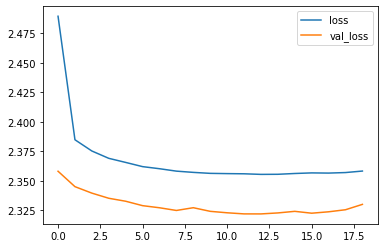

In [193]:
pd.DataFrame({'loss':loss,
             'val_loss':val_loss}).plot()

loss와 val_loss에 대한 그래프 epoch 16을 기준으로 val_loss가 상승하는 것을 볼 수 있음

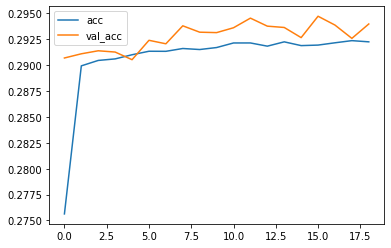

In [194]:
pd.DataFrame({'acc':acc,
             'val_acc':val_acc}).plot()

val_acc도 epoch 16에서 최고로 상승

In [195]:
def grid_search(paramgrids, trainset, testset, modelf=tuning_model,
                   epoch=20, batch=512, val_split=.2):
    import numpy as np
    best = {}
    best['model'],best['params'],best['score'],best['step'] = None,{},0,0
    for params in retAllparams(paramgrids):
        print("now trying params is", params)
        m = tuning_model(**params)
        h = m.fit(*trainset, epochs=epoch, verbose=0,
                  batch_size=batch, validation_split=val_split)
        maxidx = np.array(h.history['val_acc']).argmax()
        if h.history['val_acc'][maxidx] > best['score']:
            prtstr = "now best val score is %.5f at %d step"
            print(prtstr %(h.history['val_acc'][maxidx], maxidx))
            best['step'], best['params'] = maxidx, params
            best['score'] = h.history['val_acc'][maxidx]
            
    m = tuning_model(**best['params'])
    h = m.fit(*trainset, epochs=best['step'], batch_size=batch,
          validation_data = testset)
    print('test score is', h.history['val_acc'][-1])
    return m, h

In [196]:
def retAllparams(d):
    ret = []
    for i, (k, vs) in enumerate(d.items()):
        if i == 0:
            for v in vs:
                init = {}
                init[k] = v
                ret.append(init)
        else:
            subAll = []
            for v in vs:
                sub = []
                for dct in ret:
                    dt = dct.copy()
                    dt[k] = v
                    sub.append(dt)
                subAll = subAll + sub
            ret = subAll
    return ret

In [197]:
paramgrids = {'lr': [0.001], 'alpha':[0.0005]}
grid = grid_search(paramgrids, 
                   (X_train_scaled, one_hot_y_train), 
                   (X_test_scaled, one_hot_y_test))

now trying params is {'lr': 0.001, 'alpha': 0.0005}
now best val score is 0.29653 at 17 step
Train on 658486 samples, validate on 219496 samples
Epoch 1/17
658486/658486 [==============================] - 6s 10us/step - loss: 2.4921 - acc: 0.2736 - val_loss: 2.3568 - val_acc: 0.2905
Epoch 2/17
658486/658486 [==============================] - 5s 8us/step - loss: 2.3852 - acc: 0.2897 - val_loss: 2.3456 - val_acc: 0.2904
Epoch 3/17
658486/658486 [==============================] - 5s 8us/step - loss: 2.3752 - acc: 0.2898 - val_loss: 2.3389 - val_acc: 0.2905
Epoch 4/17
658486/658486 [==============================] - 5s 8us/step - loss: 2.3689 - acc: 0.2905 - val_loss: 2.3354 - val_acc: 0.2901
Epoch 5/17
658486/658486 [==============================] - 5s 8us/step - loss: 2.3657 - acc: 0.2903 - val_loss: 2.3323 - val_acc: 0.2912
Epoch 6/17
658486/658486 [==============================] - 5s 8us/step - loss: 2.3618 - acc: 0.2910 - val_loss: 2.3322 - val_acc: 0.2918
Epoch 7/17
658486/658486 [

## layer 추가

In [198]:
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from keras.optimizers import rmsprop
from keras import regularizers

In [199]:
m = Sequential()

m.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0005), input_shape=(25, )))
m.add(Dropout(0.5))
m.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
m.add(Dropout(0.5))
m.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0005)))
m.add(Dropout(0.5))
m.add(Dense(39, activation='softmax'))

m.compile(optimizer=rmsprop(lr=0.001),loss='categorical_crossentropy', metrics=['acc'])

m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 512)               13312     
_________________________________________________________________
dropout_39 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_102 (Dense)            (None, 64)                32832     
_________________________________________________________________
dropout_40 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_103 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_41 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_104 (Dense)            (None, 39)                2535      
Total para

dropout과 Dense를 추가해서 모델을 수정

In [200]:
history = m.fit(X_train_scaled, one_hot_y_train, 
                epochs=best_step, batch_size=512, 
                validation_data=(X_test_scaled, one_hot_y_test))

Train on 658486 samples, validate on 219496 samples
Epoch 1/19
658486/658486 [==============================] - 8s 12us/step - loss: 2.5196 - acc: 0.2771 - val_loss: 2.3867 - val_acc: 0.2880
Epoch 2/19
658486/658486 [==============================] - 6s 10us/step - loss: 2.4208 - acc: 0.2864 - val_loss: 2.3769 - val_acc: 0.2877
Epoch 3/19
658486/658486 [==============================] - 6s 10us/step - loss: 2.4109 - acc: 0.2869 - val_loss: 2.3717 - val_acc: 0.2881
Epoch 4/19
658486/658486 [==============================] - 6s 10us/step - loss: 2.4059 - acc: 0.2868 - val_loss: 2.3663 - val_acc: 0.2880
Epoch 5/19
658486/658486 [==============================] - 6s 10us/step - loss: 2.4028 - acc: 0.2869 - val_loss: 2.3662 - val_acc: 0.2893
Epoch 6/19
658486/658486 [==============================] - 6s 10us/step - loss: 2.4004 - acc: 0.2874 - val_loss: 2.3629 - val_acc: 0.2903
Epoch 7/19
658486/658486 [==============================] - 6s 10us/step - loss: 2.3983 - acc: 0.2874 - val_loss: 

epoch가 17일때 val_acc가 0.2942로 최고 높음


# XGBoost

GBM(Gradient Boost Machine) 기반
- 느린 수행시간 및 과적합 규제 부재 등의 문제 해결을 위해 개발한 알고리즘
- 균형트리분할(Level Wise) 방식을 사용하여 최적화 된 결과를 얻는 알고리즘

장점
- 병렬 CPU 환경에서 병렬 학습이 가능해 기존 GBM보다 빠르게 학습
- 분류에 있어서 예측 성능 높음

단점
- 과적합이 빠르게 되고 시간이 오래 걸림


1. 뛰어난 예측성능
2. GBM대비 빠른수행시간
3. 과적합규제, Tree Pruning
4. 자체내장된 교차검증, 결손 값 자체처리

In [40]:
from xgboost import XGBClassifier
xgbrfr = XGBClassifier()
xgbrfr.fit(X_train_scaled,y_train)
y_pred = xgbrfr.predict(X_test_scaled)
print("Training set score: {:.3f}".format(xgbrfr.score(X_train_scaled, y_train)))
print("Test set score: {:.3f}".format(xgbrfr.score(X_test_scaled, y_test)))

C:\Users\CPB06GameN\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\CPB06GameN\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training set score: 0.379
Test set score: 0.347


시간이 오래걸려서 default값으로만 진행
 - train accuracy : 0.379
 - Test accuracy : 0.349

In [44]:
print(classification_report(y_test,y_pred))

C:\Users\CPB06GameN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                             precision    recall  f1-score   support

                      ARSON       0.15      0.02      0.03       380
                    ASSAULT       0.22      0.19      0.20     19183
                 BAD CHECKS       0.00      0.00      0.00       100
                    BRIBERY       0.00      0.00      0.00        63
                   BURGLARY       0.26      0.08      0.12      9109
         DISORDERLY CONDUCT       0.20      0.05      0.09      1038
DRIVING UNDER THE INFLUENCE       0.14      0.01      0.01       593
              DRUG/NARCOTIC       0.39      0.46      0.42     13506
                DRUNKENNESS       0.12      0.01      0.01      1105
               EMBEZZLEMENT       0.00      0.00      0.00       295
                  EXTORTION       0.00      0.00      0.00        55
            FAMILY OFFENSES       0.25      0.01      0.02       115
     FORGERY/COUNTERFEITING       0.22      0.07      0.11      2648
                      FRAUD      

모델이 예측한 값과 실제값을 비교하였을 때, 0.35의 정확도를 보여준다.

# 최종 모델


- LightGBM : 0.35
- CatBoost : 0.34
- Deep Learning : 0.29
- XGBoost : 0.35


시간과 정확도를 고려했을 때, LightGBM이 최종 모델

이러한 모델을 좀 더 개발하여 정확도를 높이고 범죄 알림앱 서비스를 개발하여 사전에 범죄를 예방할 수 있을 것입니다.

현재 미국에서는 다음과 같은 방식으로 활용을 하고 있습니다.
 - IBM의 Crush
 - 노스포인트 사의 Compas
 - Predpol
 - CrimeScan
